In [9]:
DATA_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/data2/' # "./../"
DATA_VERSION = 'oct22'
RESULTS_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/results/'
SHAM = True

########################################################################################
sham_str = '_wSham' if SHAM else ''

In [2]:
# USE WITH CAUTION!!! DONT USE DURING DEVELOPMENT
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ann
from scipy.sparse import issparse

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors

import datetime

#plt.rcParams['figure.dpi'] = 300

#sc.logging.print_versions()

# Can we see differences on a bulk level for the coarse cell type specific DE genes?

In [4]:
adata = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_umaps.h5ad')

adata.obs['region'] = adata.obs['region'].cat.rename_categories({'Skull': 'Calvaria'})

Subset to CD45+

In [5]:
bones_no_scapula = ['Femur', 'Humerus', 'Pelvis', 'Calvaria', 'Vertebra']

CD45_cts = [
    'progenitors',
    'neutrophil',
    'monocyte',
    'B cell',
    'T cell',
    'NK cell',
    'NK-T cell',
    'dendritic cell',
    'macrophage',
    'microglia',
    #'erythroid precursor',
    #'erythroid cell',
    'basophil',
    #'structural cell',
    #'brain cell',
    'megakaryocyte',
    'innate lymphoid cell',
]

adata = adata[adata.obs["level1"].isin(CD45_cts) & adata.obs["region"].isin(bones_no_scapula)]

adata.obs["Calvaria"] = adata.obs["region"].apply(lambda b: b if b == "Calvaria" else "other")

Trying to set attribute `.obs` of view, copying.


Get DE genes from `03S_heatmap_plots_and_others_no_scapula_strict_threshold.ipynb`: located in `./tmp_results` (ideally these results were saved in the RESULTS_DIR ... maybe change this at some point)

In [6]:
# Define results path of per cell type DE genes function

# note that these tables are from a LFchange > 2 threshold. 

# level is in ["level1", "level2"], condition is in ["Naive", "Sham", "MCAO"]
DE_path = lambda level, condition: f"./tmp_results/DE_genes_{level}_{condition}.csv"

### Find and plot genes that we should be able to validate with bulk

In [7]:
def plot_violins(adata, genes, n_cols = 3, plt_size_factor = 4, save=False):
    """
    """

    # Violin plots
    n_subplots = len(genes)
    n_rows = n_subplots // n_cols + bool(n_subplots % n_cols)
    
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(plt_size_factor*1.3*n_cols,plt_size_factor*n_rows))
    axs = axs.flatten()
        
    for i, ax in enumerate(axs):
        if i < n_subplots:
            gene = genes[i]
            sc.pl.violin(adata, gene, groupby="region", stripplot=False, show=False, ax=ax)
        else:
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
                
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)
    plt.show()
    
    if save:
        Path(save.rsplit("/",1)[0]).mkdir(parents=True, exist_ok=True)
        fig.savefig(save, bbox_inches = "tight", transparent=True)

In [22]:
a_tmp = adata[:,["Nr4a1", "Osm", "Il1b"]].copy()

In [19]:
df

,scores,names,logfoldchanges,pvals,pvals_adj
6,31.115499,Egr1,2.635774,3.408464e-201,8.320548e-198
28,16.119583,Ptgs2,3.234773,1.445253e-57,6.692813e-56
45,11.904716,Egr3,1.903835,1.989775e-32,2.840541e-31
85,9.355991,Egr2,2.637684,1.044958e-20,8.000107e-20
184,6.299376,Nr4a3,2.161275,3.134456e-10,1.247940e-09
192,6.186085,Fosl1,3.540789,6.467517e-10,2.529570e-09
341,4.360984,Ighg1,6.033678,1.311288e-05,3.574104e-05


... storing 'Calvaria' as categorical


,scores,names,logfoldchanges,pvals,pvals_adj,mean_expr_Calvaria,mean_expr_other_bones,perc_expr>0_Calvaria,perc_expr>0_other_bones
6,23.157846,Osm,2.026050,1.314787e-109,3.209583e-106,0.373655,0.105470,0.347473,0.140148
7,23.065519,Nr4a1,2.898545,1.723398e-108,3.386548e-105,0.224550,0.033205,0.252033,0.051477
18,19.473692,Egr1,2.589368,1.253477e-79,1.127338e-76,0.308681,0.058351,0.217391,0.066726
19,19.050659,Ptgs2,3.102618,2.005902e-76,1.713842e-73,0.265362,0.034768,0.182043,0.033000
25,17.888372,Il1b,1.972563,3.183123e-68,2.014563e-65,0.505308,0.154890,0.246023,0.110457
29,16.482315,Thbs1,1.607635,1.141355e-58,6.501158e-56,0.366531,0.135643,0.255214,0.128207
52,11.926395,Csrnp1,1.304752,3.822730e-32,1.020669e-29,0.091783,0.038173,0.151997,0.071163
53,11.570349,Atf3,2.498300,2.553885e-30,6.417764e-28,0.069569,0.012670,0.083068,0.022107
77,9.304091,Nr4a2,2.877688,2.566511e-20,1.699866e-18,0.044302,0.006144,0.052315,0.012183
86,8.572433,Acod1,2.419305,1.592602e-17,7.014018e-16,0.039163,0.007439,0.045246,0.010570


### Genes in cond = Naive we should be able to validate with bulk data: ###


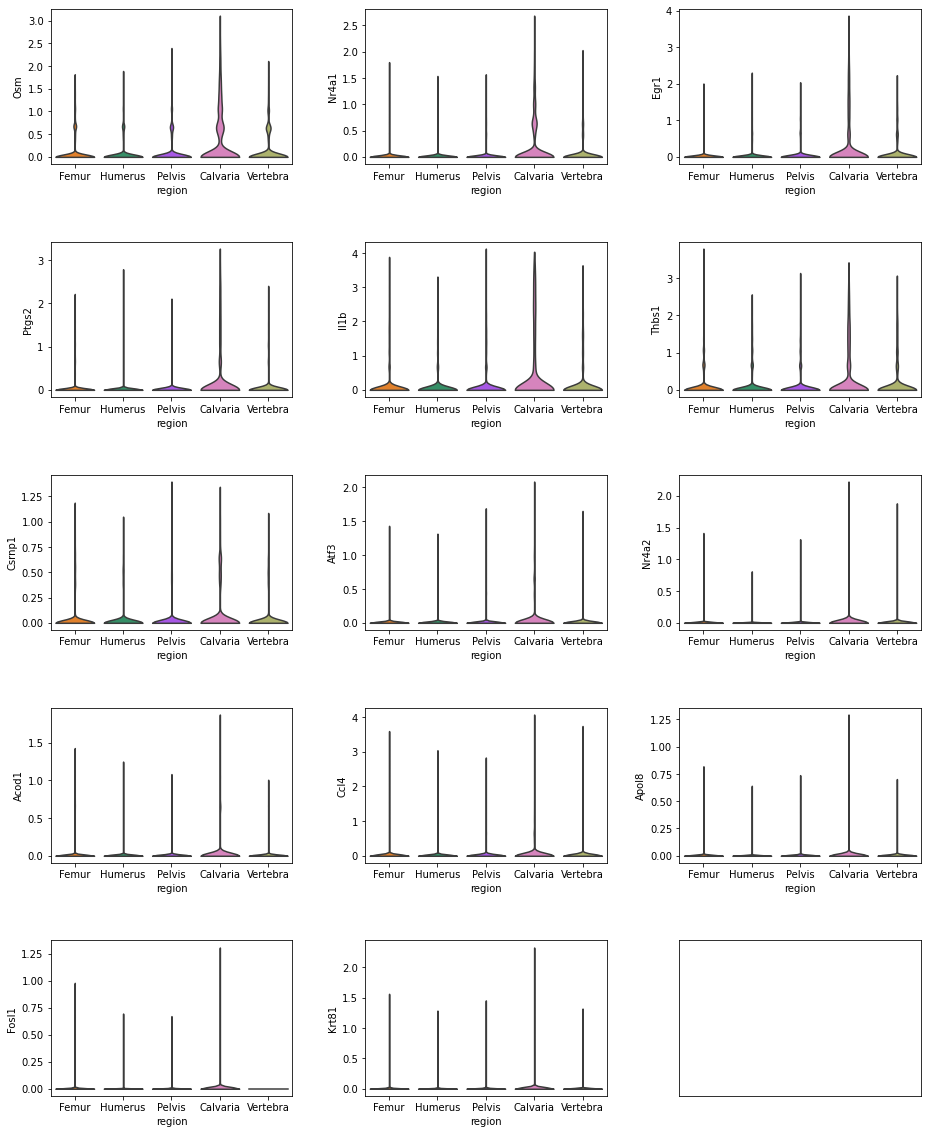

No genes for Sham


... storing 'Calvaria' as categorical


,scores,names,logfoldchanges,pvals,pvals_adj,mean_expr_Calvaria,mean_expr_other_bones,perc_expr>0_Calvaria,perc_expr>0_other_bones
6,31.115499,Egr1,2.635774,3.408464e-201,8.320548e-198,0.284768,0.051652,0.199108,0.052103
28,16.119583,Ptgs2,3.234773,1.445253e-57,6.692813e-56,0.056864,0.006196,0.049427,0.007162
45,11.904716,Egr3,1.903835,1.989775e-32,2.840541e-31,0.030713,0.008300,0.040255,0.011313
85,9.355991,Egr2,2.637684,1.044958e-20,8.000107e-20,0.011919,0.001925,0.017452,0.002932
184,6.299376,Nr4a3,2.161275,3.134456e-10,1.247940e-09,0.005729,0.001284,0.009427,0.002180
192,6.186085,Fosl1,3.540789,6.467517e-10,2.529570e-09,0.004165,0.000359,0.006369,0.000623
341,4.360984,Ighg1,6.033678,1.311288e-05,3.574104e-05,0.006692,0.000102,0.008662,0.000130


### Genes in cond = MCAO we should be able to validate with bulk data: ###


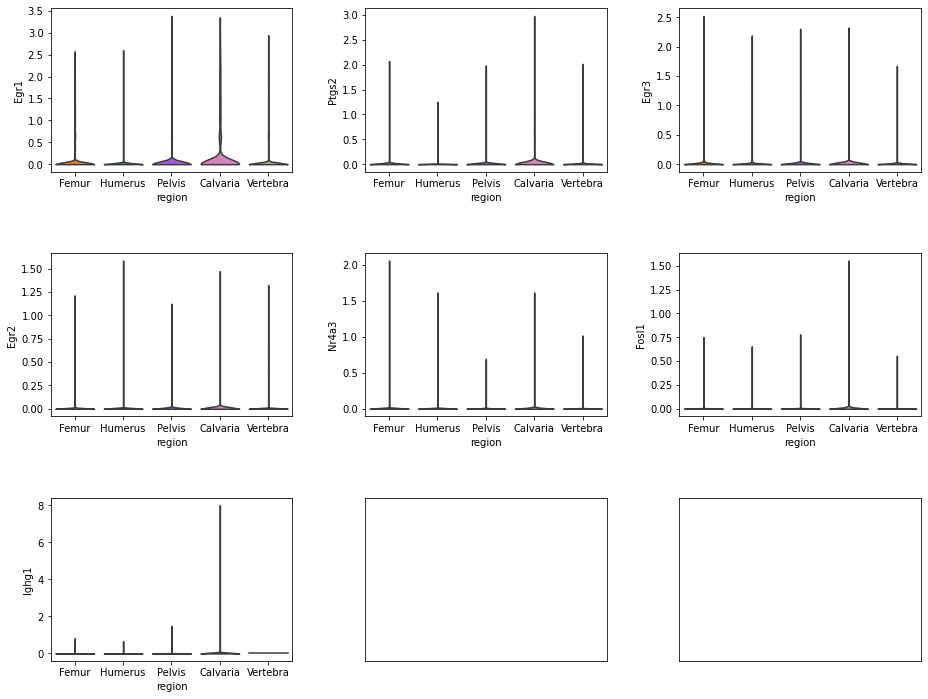

In [8]:
PVAL_TH = 0.05
LFC_TH = 1

for condition in ["Naive", "Sham", "MCAO"]:
    
    DE_genes = pd.read_csv(DE_path("level1",condition),index_col=0)
    
    genes = DE_genes.loc[DE_genes["celltype"].isin(CD45_cts) & (DE_genes["combination"] == "skull_only")].index.tolist()
    
    if len(genes) == 0:
        print(f"No genes for {condition}")
        continue
    
    a_tmp = adata[adata.obs["condition"] == condition].copy()
    
    sc.tl.rank_genes_groups(a_tmp, "Calvaria")
    
    df = sc.get.rank_genes_groups_df(a_tmp, "Calvaria")
    
    df = df.loc[df["names"].isin(genes) & (df["pvals_adj"] < PVAL_TH) & (df["logfoldchanges"] > LFC_TH)]
    
    ### TODO: save this csv file
    df.to_csv(RESULTS_DIR + f"DE_tests/DE_tests_bulk/genes_from_ct_specific_tests/DE_genes_level1_{condition}_LFchange_{LFC_TH}.csv")
    
    # Get mean expressions and percentage of positive cells within each bone
    df[f"mean_expr_other_bones"] = np.array(np.mean(a_tmp[a_tmp.obs["Calvaria"]=="other",df["names"].values].X,axis=0))[0,:]
    for region in a_tmp.obs["region"].cat.categories:
        df[f"mean_expr_{region}"] = np.array(np.mean(a_tmp[a_tmp.obs["region"]==region,df["names"].values].X,axis=0))[0,:]
    df[f"perc_expr>0_other_bones"] = np.array(np.mean(a_tmp[a_tmp.obs["Calvaria"]=="other",df["names"].values].X > 0,axis=0))[0,:]        
    for region in a_tmp.obs["region"].cat.categories:
        df[f"perc_expr>0_{region}"] = np.array(np.mean(a_tmp[a_tmp.obs["region"]==region,df["names"].values].X > 0,axis=0))[0,:]
        
    display(df[[
        "scores", "names", "logfoldchanges", "pvals", "pvals_adj", 
        "mean_expr_Calvaria", "mean_expr_other_bones", "perc_expr>0_Calvaria", "perc_expr>0_other_bones"
    ]])
    
    print(f"### Genes in cond = {condition} we should be able to validate with bulk data: ###")
    
    plot_violins(a_tmp, df["names"].tolist(), n_cols = 3, save=False)
    

# Create list of DE genes between bulks

In [5]:
DATA_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/data2/' # "./../"
DATA_VERSION = 'oct22'
RESULTS_DIR = '/lustre/groups/ml01/workspace/louis.kuemmerle/projects/A1/results/'
SHAM = True

########################################################################################
sham_str = '_wSham' if SHAM else ''

In [6]:
# USE WITH CAUTION!!! DONT USE DURING DEVELOPMENT
import warnings
warnings.filterwarnings("ignore")

In [7]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ann
from scipy.sparse import issparse

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors

import datetime

#plt.rcParams['figure.dpi'] = 300

#sc.logging.print_versions()

In [10]:
adata = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}{sham_str}_umaps.h5ad')

adata.obs['region'] = adata.obs['region'].cat.rename_categories({'Skull': 'Calvaria'})

bones_no_scapula = ['Femur', 'Humerus', 'Pelvis', 'Calvaria', 'Vertebra']
adata = adata[adata.obs["region"].isin(bones_no_scapula)]

adata.obs['Calvaria'] = adata.obs['region'].astype(str)
adata.obs.loc[adata.obs['Calvaria'] != 'Calvaria', 'Calvaria'] = "other bones"
adata.obs['Calvaria'] = adata.obs['Calvaria'].astype("category")

#### 1. DE test on all cells

In [12]:
for condition in ["Naive", "Sham", "MCAO"]:
    a = adata[adata.obs["condition"] == condition].copy()
    sc.tl.rank_genes_groups(a, groupby="Calvaria")
    df = sc.get.rank_genes_groups_df(a, "Calvaria")
    df = df.loc[(df["pvals_adj"] < 0.05) & (df["logfoldchanges"] > 1)]
    df = df.reset_index()
    
    df.to_csv(os.path.join(RESULTS_DIR, "DE_tests", "DE_tests_bulk", f"DE_genes_bulk_{condition}_skull_vs_rest_LFchange_1.csv"))
    
    df = sc.get.rank_genes_groups_df(a, "other bones")
    df = df.loc[(df["pvals_adj"] < 0.05) & (df["logfoldchanges"] > 1)]
    df = df.reset_index()    
    
    df.to_csv(os.path.join(RESULTS_DIR, "DE_tests", "DE_tests_bulk", f"DE_genes_bulk_{condition}_rest_vs_skull_LFchange_1.csv"))    

#### 2. DE test no erythroid and structural + brain cells

In [13]:
CD45_cts = [
    'progenitors',
    'neutrophil',
    'monocyte',
    'B cell',
    'T cell',
    'NK cell',
    'NK-T cell',
    'dendritic cell',
    'macrophage',
    'microglia',
    #'erythroid precursor',
    #'erythroid cell',
    'basophil',
    #'structural cell',
    #'brain cell',
    'megakaryocyte',
    'innate lymphoid cell',
]

adata_CD45 = adata[adata.obs["level1"].isin(CD45_cts)]

for condition in ["Naive", "Sham", "MCAO"]:
    a = adata_CD45[adata_CD45.obs["condition"] == condition].copy()
    sc.tl.rank_genes_groups(a, groupby="Calvaria")
    df = sc.get.rank_genes_groups_df(a, "Calvaria")
    df = df.loc[(df["pvals_adj"] < 0.05) & (df["logfoldchanges"] > 1)]
    df = df.reset_index()
    
    df.to_csv(os.path.join(RESULTS_DIR, "DE_tests", "DE_tests_bulk", f"DE_genes_bulk_CD45_{condition}_skull_vs_rest_LFchange_1.csv"))
    
    df = sc.get.rank_genes_groups_df(a, "other bones")
    df = df.loc[(df["pvals_adj"] < 0.05) & (df["logfoldchanges"] > 1)]
    df = df.reset_index()    
    
    df.to_csv(os.path.join(RESULTS_DIR, "DE_tests", "DE_tests_bulk", f"DE_genes_bulk_CD45_{condition}_rest_vs_skull_LFchange_1.csv"))